### Prediction Accuracy Graphs

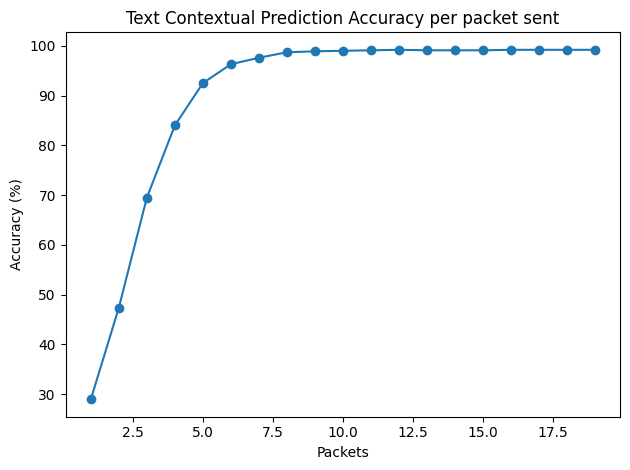

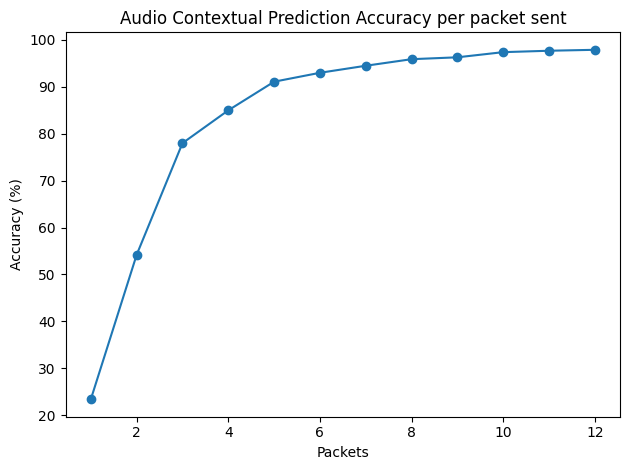

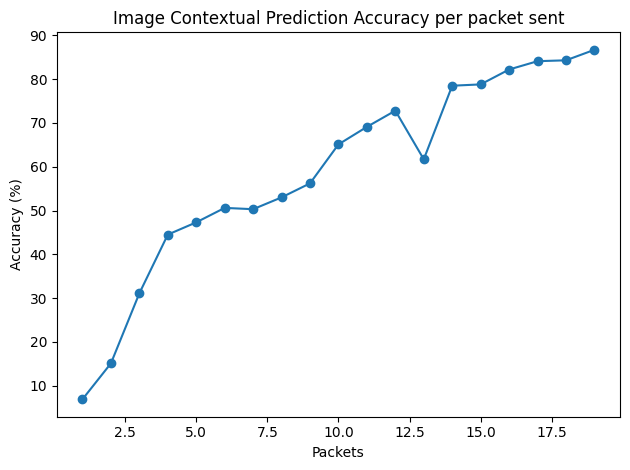

In [15]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

# ─── locate script directory ───────────────────────────────────────────
try:
    script_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    script_dir = os.getcwd()

# ─── map of display names to log‐filenames ─────────────────────────────
log_files = {
    "Text" : "text_pred_acc_log.txt",
    "Audio": "audio_pred_acc_log.txt",
    "Image": "image_pred_acc_log.txt",
}

# ─── regex to pull out “acc=NN.N%” ──────────────────────────────────────
acc_pattern = re.compile(r"acc=([\d\.]+)%")

for label, fname in log_files.items():
    path = os.path.join(script_dir, fname)
    if not os.path.exists(path):
        print(f"⚠️  {label} log not found at {path}")
        continue

    # ─── read & extract accuracies ────────────────────────────────────
    with open(path, "r") as f:
        lines = f.readlines()

    accuracies = []
    for line in lines:
        m = acc_pattern.search(line)
        if m:
            accuracies.append(float(m.group(1)))

    if not accuracies:
        print(f"⚠️  No accuracies found in {fname}")
        continue

    # ─── build DataFrame & print ───────────────────────────────────────
    df = pd.DataFrame({
        "packets": range(1, len(accuracies) + 1),
        "accuracy (%)": accuracies
    })
    # print(f"\n=== {label} accuracy per packets ===")
    # print(df.to_string(index=False))

    # ─── plot in its own figure ───────────────────────────────────────
    plt.figure()
    plt.plot(df["packets"], df["accuracy (%)"], marker="o")
    plt.xlabel("Packets")
    plt.ylabel("Accuracy (%)")
    plt.title(f"{label} Contextual Prediction Accuracy per packet sent")
    plt.tight_layout()

# ─── show all three windows ────────────────────────────────────────────
plt.show()


### Encode, Decode, Prediction Inference Timing Table

In [16]:
from pathlib import Path
import pandas as pd

csv_files = {
    "Text":  {"timing": "text_timing.csv",  "pred": "text_prediction.csv"},
    "Audio": {"timing": "audio_timing.csv", "pred": "audio_prediction.csv"},
    "Image": {"timing": "image_timing.csv", "pred": "image_prediction.csv"},
}

records = []

for label, files in csv_files.items():
    encode_ms = decode_ms = pred_ms = float("nan")

    # 1) encode / decode come from *_timing.csv
    try:
        df_t = pd.read_csv(files["timing"])
        for _, row in df_t.iterrows():
            m, v = row["metric"], row["avgMilliseconds"]
            if m.startswith("embed"):
                encode_ms = v
            elif m.startswith("decode"):
                decode_ms = v
    except FileNotFoundError:
        print(f"⚠️  {files['timing']} not found")

    # 2) prediction time comes from *_prediction.csv
    try:
        df_p = pd.read_csv(files["pred"])
        if "metric" in df_p.columns:          # one-row summary
            sel = df_p["metric"] == "avgPredictMs"
            if sel.any():
                pred_ms = float(df_p.loc[sel, "value"].iloc[0])
        elif "avgPredictMs" in df_p.columns:  # per-packets log
            pred_ms = df_p["avgPredictMs"].mean()
    except FileNotFoundError:
        print(f"⚠️  {files['pred']} not found")

    records.append(
        dict(Modality=label, Encode=encode_ms, Decode=decode_ms, Prediction=pred_ms)
    )

# ── print table ─────────────────────────────────────────────────────────
table = (
    pd.DataFrame(records)
      .set_index("Modality")
      .round(2)
      .rename_axis(None)
)

print(f"\n=== timing metrics ===")
print("\n"+table.to_string())



=== timing metrics ===

        Encode   Decode  Prediction
Text    142.00  3594.79     1333.87
Audio  2637.31  7659.58     3532.70
Image  2251.33   192.57      225.41


### Image, Audio, and Text Sizing Table

In [17]:
from pathlib import Path
import pandas as pd
import textwrap, sys

# ─── explicit map of modality → filename ────────────────────────────────
size_files = {
    "Text" :  "text_sizes.csv",
    "Audio":  "audio_sizes.csv",
    "Image":  "image_sizes.csv",
}

# ─── load and display each table ───────────────────────────────────────
for label, fname in size_files.items():
    path = Path(fname)
    if not path.exists():
        print(f"⚠️  {fname}: file not found\n", file=sys.stderr)
        continue

    df = pd.read_csv(path)

    # tidy up numeric precision for printing (optional)
    pd.set_option("display.precision", 2)

    print(f"\n=== {label} – size metrics ===")
    print(df.to_string(index=False))



=== Text – size metrics ===
      fileName  txtBytes  latentBytes
 words_100.txt       578         4096
words_1000.txt      6110         4096
words_1335.txt      8117         4096
 words_500.txt      3042         4096

=== Audio – size metrics ===
    baseName  wavBytes  mp3Bytes  oggBytes  opusBytes  flacBytes  latentBytes
test_audio_1  50274474   4332332   3519010    4777345   22250775      2733897

=== Image – size metrics ===
resolution  pngBytes  jpgBytes  webpBytes  jxlBytes  avifBytes  latentBytes
        4k  10642635   2383140     593688    641561     282542       139411
     1440p   5838923   1351930     375716    342884     192680       139396
     1080p   3707337    887774     271582    238832     145810       139244
      720p   1839057    454142     153162    130725      89329       139112


### Reconstruction Accuracy Table

In [18]:
from pathlib import Path
import pandas as pd

acc_files = {
    "Text" :  "text_acc.csv",
    "Audio":  "audio_acc.csv",
    "Image":  "image_acc.csv",
}

rows = []
for label, fname in acc_files.items():
    path = Path(fname)
    if not path.exists():
        print(f"⚠️  {fname} not found")
        rows.append((label, float("nan")))
        continue

    df = pd.read_csv(path)
    avg = df["accuracy"].mean()    # files use header: fileName,accuracy
    rows.append((label, round(avg, 4)))

table = pd.DataFrame(rows, columns=["Modality", "Avg Accuracy"]).set_index("Modality")
pd.set_option("display.precision", 4)
print("\n" + table.to_string())



          Avg Accuracy
Modality              
Text            0.6969
Audio           0.8676
Image           0.9994


# Semantic Comm


=== Audio: KB lookup times ===
 kbSize         fileName  lookupMs
      1 test_audio_1.mp3      6.48
      2 test_audio_1.wav      6.79
      3 test_audio_2.mp3      4.48

=== Image: KB lookup times ===
 kbSize            fileName  lookupMs
      1 astronaut_1080p.jpg      0.29
      2 astronaut_1440p.jpg      0.19
      3    astronaut_4k.jpg      0.40
      4  astronaut_720p.jpg      0.34

=== Text: KB lookup times ===
 kbSize       fileName  lookupMs
      1  words_100.txt      0.03
      2 words_1000.txt      0.04
      3 words_1335.txt      0.03
      4  words_500.txt      0.03


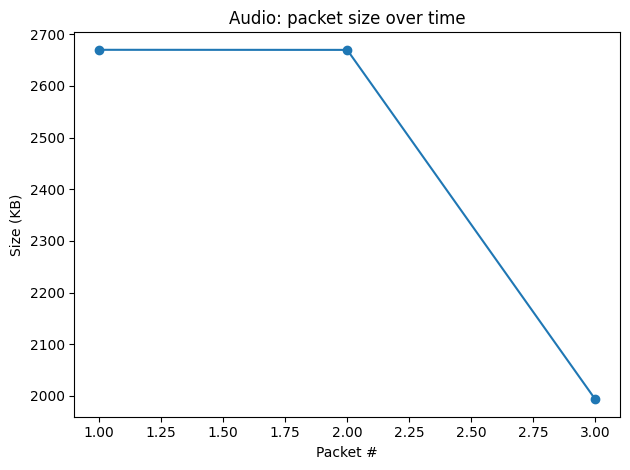

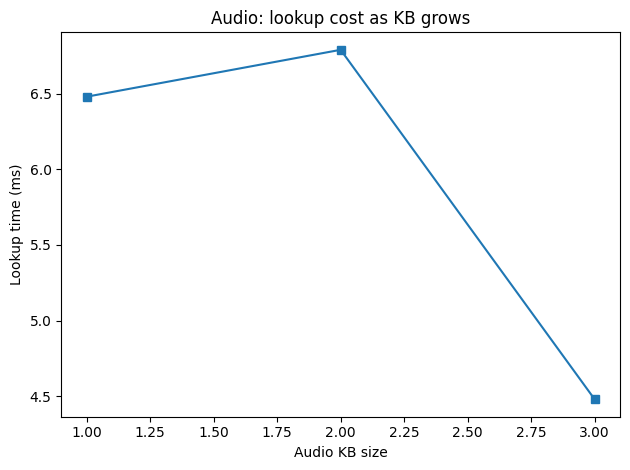

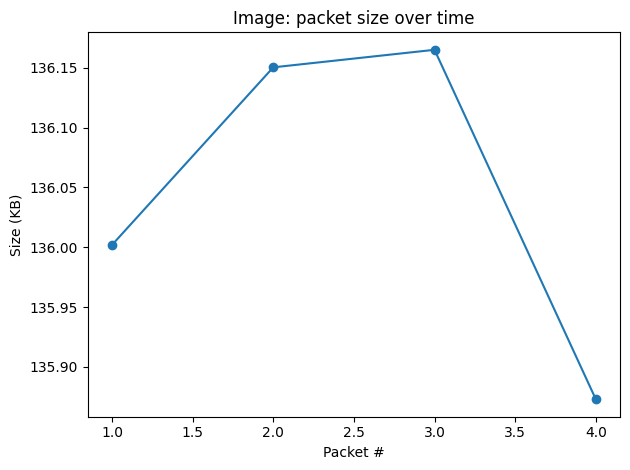

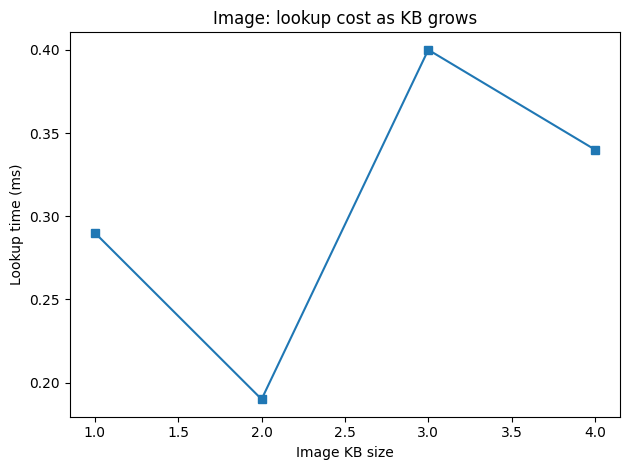

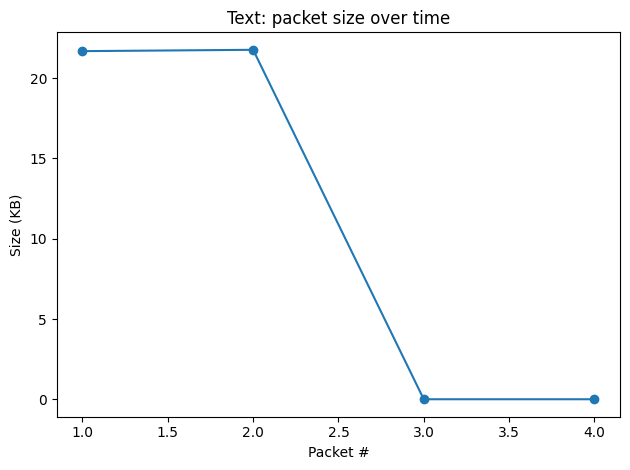

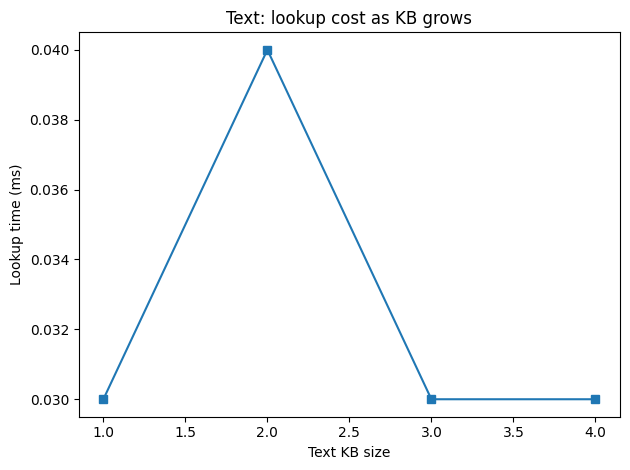

In [19]:
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.autolayout"] = True

# ─── 1) point the script to your CSVs ───────────────────────────────────
comm_files = {
    "Text" :  "text_comm.csv",
    "Audio":  "audio_comm.csv",
    "Image":  "image_comm.csv",
}

kb_files = {
    "Text" :  "text_knowledgebase.csv",
    "Audio":  "audio_knowledgebase.csv",
    "Image":  "image_knowledgebase.csv",
}
# ───────────────────────────────────────────────────────────────────────

HERE = Path.cwd()

for label in sorted(set(comm_files) | set(kb_files)):

    # 1. Packet-size plot (bytes → KB) ----------------------------------
    comm_path = HERE / comm_files.get(label, "")
    if comm_path.exists():
        df = pd.read_csv(comm_path)
        plt.figure()
        plt.plot(df["packet"], df["bytes"] / 1024, marker="o")
        plt.xlabel("Packet #")
        plt.ylabel("Size (KB)")             # ← KB scale
        plt.title(f"{label}: packet size over time")
    else:
        print(f"⚠️  {label}: {comm_path.name} not found – skipping packet plot",
              file=sys.stderr)

    # 2. KB-lookup latency plot & table ---------------------------------
    kb_path = HERE / kb_files.get(label, "")
    if kb_path.exists():
        df = pd.read_csv(kb_path)
        df.insert(0, "kbSize", range(1, len(df) + 1))

        plt.figure()
        plt.plot(df["kbSize"], df["lookupMs"], marker="s")
        plt.xlabel(f"{label} KB size")
        plt.ylabel("Lookup time (ms)")
        plt.title(f"{label}: lookup cost as KB grows")

        pd.set_option("display.precision", 2)
        print(f"\n=== {label}: KB lookup times ===")
        print(df.to_string(index=False))
    else:
        print(f"⚠️  {label}: {kb_path.name} not found – skipping KB plot/table",
              file=sys.stderr)

plt.show()
